
Making MAX More Reliable
Working toward an average of 90% on-time performance

We’re focused on making MAX better — and that means providing more reliable service, safely. On average in 2015, about one in every five trips was delayed. We know how frustrating this can be for our riders — you’ve got places you need to be and it’s our responsibility to help get you there on time. That’s why we’re addressing many of the areas that affect our system’s on-time performance, including maintenance, training and partnerships.

Our long-term goal is to raise on-time performance to 90 percent.

MAX is a very complex system that operates about 22½ hours a day with a fleet of 145 vehicles. Right now approximately one-third of MAX delays involve events beyond our immediate control, like cars blocking the tracks or passengers in need of medical attention. The other two-thirds, however, fall within our direct control, including trains with mechanical issues, signals malfunctioning, stuck switches or many other operating issues. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import google.datalab.storage as storage
from io import BytesIO

load csv from GCP storage

In [5]:
mybucket = storage.Bucket('jjacobsbucket/Thinkful')
rail = mybucket.object('rail_data_sub.csv')

uri = rail.uri
%gcs read --object $uri --variable data

rail = pd.read_csv(BytesIO(data))
rail.head()

,delay,timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,routeNumber,tripID,type,vehicle_location_longitude,vehicle_location_latitude
0,-311,2016-09-01 15:29:43 UTC,7601,1,9303,2,150,6621323,rail,-122.675465,45.524836
1,-263,2016-09-03 01:11:53 UTC,7601,1,9303,2,150,6621352,rail,-122.675465,45.524836
2,-305,2016-09-02 00:31:35 UTC,7601,1,9303,2,150,6621350,rail,-122.675465,45.524836
3,-393,2016-09-03 04:11:04 UTC,7601,1,9303,2,150,6621361,rail,-122.675465,45.524836
4,-176,2016-09-01 16:33:27 UTC,7601,1,9303,2,150,6621326,rail,-122.675465,45.524836


View head to make sure the file loaded as expected.

Start exploration of data with a histogram. This histrogram shows us the number of delays grouped by length of delay. We see that most trips or sligthly delayed, a good portion are ahead of schedule, some are behind schedule. Of note is the small bin representing trains that are roughly more than 5 minutes ahead of schedule. This may be a problem with the data since Trimet trains will stop when they are more than a minute ahead of schedule.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


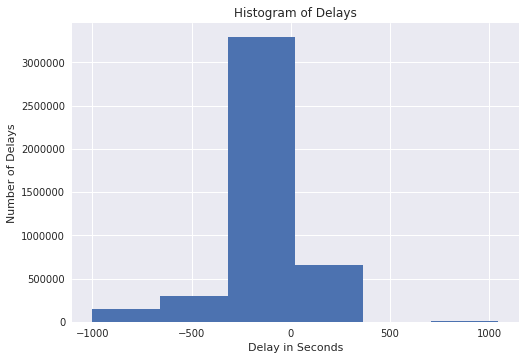

In [6]:
rail.delay.hist(bins=6)
plt.ylabel('Number of Delays')
plt.xlabel('Delay in Seconds')
plt.title('Histogram of Delays')
plt.show()

Explore the data further by using a box plot. We see that five of the train routes have very similar profiles, while route 150 has a significantly higher rate of delays

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


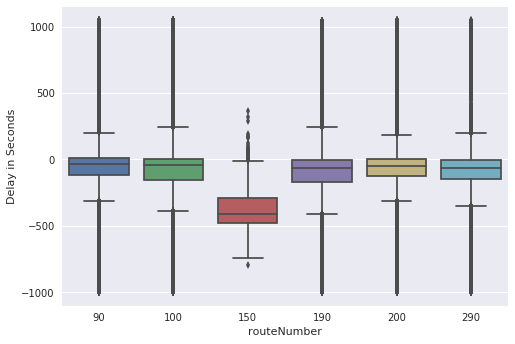

In [41]:
sns.boxplot(x='routeNumber', y='delay', data=rail)
plt.ylabel('Delay in Seconds')
plt.show()

This bar plot shows us that route 150 clearly has a much higher average delay than the other routes.

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


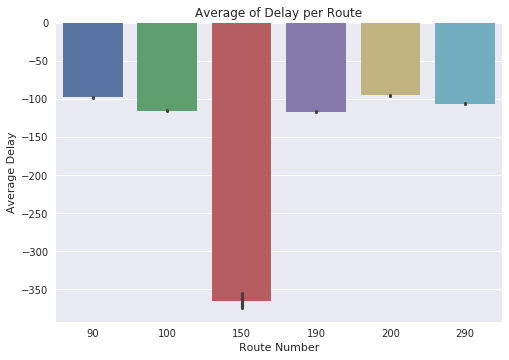

In [8]:
sns.barplot(x='routeNumber', y='delay', data=rail)
plt.ylabel('Average Delay')
plt.xlabel('Route Number')
plt.title('Average of Delay per Route')
plt.show()

This bar chart show the number of trips run on each route. Of importance is the very low number of trips run on route 150. I suspect that this route is run for special events, like NBA games that are more likely to have delays due to large passenger loads.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


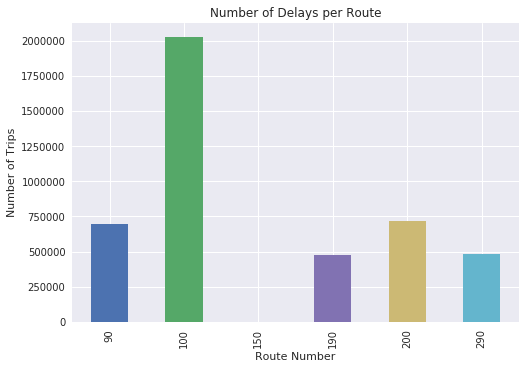

In [9]:
rail.delay.groupby(rail.routeNumber).count().plot(kind='bar')
plt.ylabel('Number of Trips')
plt.xlabel('Route Number')
plt.title('Number of Delays per Route')
plt.show()

Continue data exploration with .describe.

In [10]:
rail.delay.groupby(rail.routeNumber).describe()

,count,mean,std,min,25%,50%,75%,max
routeNumber,,,,,,,,
90,698335.0,-97.955729,208.697496,-1000.0,-120.0,-35.0,9.00,1047.0
100,2026685.0,-115.173086,217.859116,-1000.0,-153.0,-44.0,6.00,1047.0
150,1292.0,-364.814241,173.663210,-796.0,-478.0,-412.0,-289.75,368.0
190,478217.0,-116.586972,183.535165,-1000.0,-167.0,-66.0,-3.00,1046.0
200,718528.0,-95.077408,183.167709,-1000.0,-125.0,-46.0,0.00,1047.0
290,485016.0,-106.159636,174.586435,-1000.0,-146.0,-61.0,-8.00,1047.0


There is something odd about the max delays; all but route 150 are 1046/7. This is something that should be looked into further, but withou access to metadata regarding this dataset and the people who developed the data collection process, I cannot explore this further.

Trimet states that MAX is considered “on time” if it departs the station no more than 1 minute early and no more than 5 minutes late. Here I create a new column - on_time - that marks a trip as on time with a 0 and not on time with a 1.

In [19]:
rail['on_time'] = np.where((rail['delay'] > -301) & (rail['delay'] < 61), 0, 1)
rail.head()

,delay,timestamp,lastLocID,lastStopSeq,nextLocID,nextStopSeq,routeNumber,tripID,type,vehicle_location_longitude,vehicle_location_latitude,on_time
0,-311,2016-09-01 15:29:43 UTC,7601,1,9303,2,150,6621323,rail,-122.675465,45.524836,1
1,-263,2016-09-03 01:11:53 UTC,7601,1,9303,2,150,6621352,rail,-122.675465,45.524836,0
2,-305,2016-09-02 00:31:35 UTC,7601,1,9303,2,150,6621350,rail,-122.675465,45.524836,1
3,-393,2016-09-03 04:11:04 UTC,7601,1,9303,2,150,6621361,rail,-122.675465,45.524836,1
4,-176,2016-09-01 16:33:27 UTC,7601,1,9303,2,150,6621326,rail,-122.675465,45.524836,0


Calculate rate of on time trips.

In [40]:
(len(rail[rail["on_time"]==0]))/(len(rail["on_time"]))

0.8414102942487568

About 84% of all rail trips were ontime. This is short of the 90% goal that Trimet has set. This leaves us with the question, what can be done to reach this goal?

Below I briefly present an experiment that will test new doors on trains to see if they help reduce delayed trips.

According to Trimet, some delays are under their control (e.g. mechanical issues), while other delays are out of their control (e.g. autos blocking the tracks or the weather). However, Trimet (at least in their online materials) does not mention delays cause by passengers intentionally holding train doors open. All trains used by Trimet will automatically reopen if something is blocking them. Thus, I would like to test whether installing doors that will not reopen (expect in emergencies) would reduce delays.

Hypothesis: Trains fitted with does that do not automatically close will have less delays than current trimet trains.

Experiment plan:
    I would implement an A/B test to test this hypothesis.

    The A group would contain trains with doors that reopen.
    The B group would contain trains with doors that do not reopen.

    Both groups would run on all routes and at all times throughout the day.

    I would run this test for a year to control for seasonal changes.

Evaluation plan:
    I would compare data for both groups to see if there was a significant difference between the two. I would also compare the data to previous years' data to provide more context. 